In [1]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D,
                          Conv1D, Concatenate)
import tensorflow_probability as tfp

In [4]:
X = pd.read_csv("../data/1D/X.csv").values
y = pd.read_csv("../data/1D/y.csv")['cotAlpha'].values

alphas = []
for i in range(len(y)):
    angle = np.arctan(1.0/np.abs(y[i]))
    alphas.append(angle)
    
alphas = np.array(alphas)

def standardize(x):
    """Applies the normalization configuration in-place to a batch of
    inputs.
    `x` is changed in-place since the function is mainly used internally
    to standardize images and feed them to your network.
    Args:
        x: Batch of inputs to be normalized.
    Returns:
        The inputs, normalized. 
    """
    x -= np.mean(x, keepdims=True)   
    x /= np.std(x, keepdims=True) + 1e-10
    return x
X = standardize(X)
print(X.shape,y.shape)

(750481, 21) (750481,)


In [7]:
def custom_loss(y, p):
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.001 + tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)**2/(2*(sigma)**2))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)

def custom_loss_beta_distribution(y, p):
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    alpha = tf.gather(params=p, indices=[0], axis=1)
    beta = tf.gather(params=p, indices=[1], axis=1)
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    likelihood = dist.prob(y)                            
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)    

In [8]:
class RegModelAlpha1D:

    def build_image_branch(self,inputs):
        x = tf.keras.layers.Dense(256, 
                               kernel_initializer = "glorot_normal", 
                               activation='sigmoid', 
                               use_bias = True,
                               name = "hidden_i")(inputs)
        x = tf.keras.layers.Dense(2, 
                               activation= "softplus", 
                               name = "final_output")(x)

        return x
 
    def assemble_model(self):
        inputs = tf.keras.layers.Input ( shape = (21,) )
        outputs = self.build_image_branch(inputs)
        model = tf.keras.models.Model(inputs =[inputs], 
                      outputs=outputs, 
                      name = "angle_alpha_1D_x_profile_model")
        print( model.summary() )
        return model

In [9]:
start_date = datetime.datetime.now ( )
epochs = 10
batch_size = 512
model = RegModelAlpha1D().assemble_model()

model.compile(
            optimizer = tf.keras.optimizers.legacy.Adam(lr = 0.001),
            loss = custom_loss_beta_distribution
            )

history = model.fit(
                    x = X,
                    y = alphas,
                    epochs=epochs,
                    validation_split = 0.15,
                    verbose = True 
                    )

end_date = datetime.datetime.now ( )
print ( "Total Training Time = {}".format (end_date - start_date ) )

Model: "angle_alpha_1D_x_profile_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 hidden_i (Dense)            (None, 256)               5632      
                                                                 
 final_output (Dense)        (None, 2)                 514       
                                                                 
Total params: 6,146
Trainable params: 6,146
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2023-02-06 18:14:14.543455: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-06 18:14:14.846356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19935/19935 [==============================] - ETA: 0s - loss: -20.7198

2023-02-06 18:17:21.906541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19935/19935 [==============================] - 208s 10ms/step - loss: -20.7198 - val_loss: -20.7232
Epoch 2/10
19935/19935 [==============================] - 206s 10ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 3/10
19935/19935 [==============================] - 208s 10ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 4/10
19935/19935 [==============================] - 205s 10ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 5/10
19935/19935 [==============================] - 206s 10ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 6/10
19935/19935 [==============================] - 206s 10ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 7/10
19935/19935 [==============================] - 207s 10ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 8/10
19935/19935 [==============================] - 245s 12ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 9/10
19935/19935 [==============================] - 243s 12ms/step - loss: -20.7206 - val_loss: -20.7232
Epoch 10/10


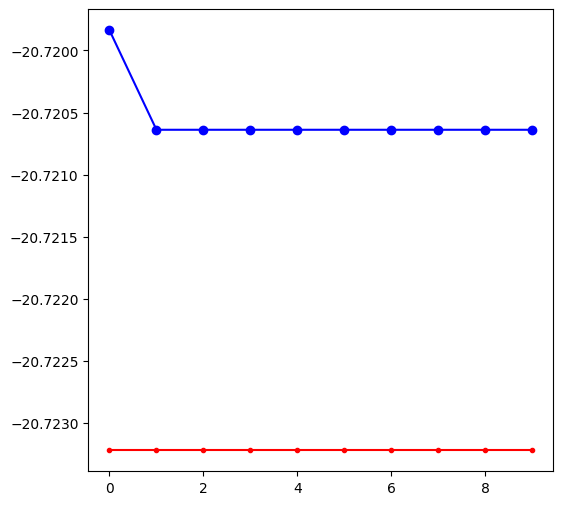

In [10]:
plt.figure(figsize = (6,6))
plt.plot(history.history["loss"], color = "blue",marker = "o")
plt.plot(history.history["val_loss"], color ="red", marker = ".")
plt.show()

### Test Phase:

In [11]:
test_recon = pd.read_csv("../data/1D/test/reconTest_1Dx.csv")
test_labels_df = pd.read_csv("../data/1D/test/labelsTest.csv")
test_labels = np.absolute(test_labels_df["cotAlpha"].values)
print(test_recon.shape, test_labels.shape)

(125498, 21) (125498,)


In [12]:
# test_inputs = test_recon.values.reshape(test_recon.shape[0],21,1)

def standardize(x):
    """Applies the normalization configuration in-place to a batch of
    inputs.
    `x` is changed in-place since the function is mainly used internally
    to standardize images and feed them to your network.
    Args:
        x: Batch of inputs to be normalized.
    Returns:
        The inputs, normalized. 
    """
    x -= np.mean(x, keepdims=True)   
    x /= np.std(x, keepdims=True) + 1e-10
    return x

test_inputs = standardize(test_recon.values)
cotAlpha_predictions = model.predict(test_inputs, batch_size = 1000)
alpha = cotAlpha_predictions[:,0]
beta = cotAlpha_predictions[:,1]
sum_term = alpha + beta
prod_term = alpha*beta
mu = alpha/(alpha+beta)
uncertainty = sum_term/(prod_term*(alpha+beta+1.0))
df = pd.DataFrame(mu, columns = ["predictions"])
df["uncertainty"] = uncertainty
# df = pd.DataFrame(cotAlpha_predictions, columns = ["predictions","uncertainty"])
# df["uncertainty"] = 0.001 + tf.math.softplus(df["uncertainty"])
df["truth"] = test_labels
df

 46/126 [=========>....................] - ETA: 0s

2023-02-06 19:05:32.277638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 0s 2ms/step


,predictions,uncertainty,truth
0,NaN,NaN,1.145240
1,NaN,NaN,1.460190
2,NaN,NaN,0.686055
3,NaN,NaN,3.290910
4,NaN,NaN,3.549410
...,...,...,...
125493,NaN,NaN,0.398301
125494,NaN,NaN,1.186930
125495,NaN,NaN,1.050710
125496,NaN,NaN,1.215030


In [ ]:
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(df["truth"], bins = 100, color = "green", histtype = "step" )
plt.hist(df["predictions"], bins = 100, color = "red", histtype = "step" )
plt.xlabel(r'$_{cot\alpha}$')
plt.legend(["truth", "1d model"])
plt.xlim([-1,9])
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [ ]:
residuals = df["truth"] - df["predictions"]
print(np.mean(residuals), np.std(residuals))
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(residuals, bins = 100, color = "red", histtype = "step")
plt.legend(["Residuals"])
# plt.xlim([-1,1])
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [ ]:
# pulls = residuals/ df["uncertainty"]
# print(np.mean(pulls), np.std(pulls))
# plt.figure(figsize = (7,5), dpi = 80)
# plt.hist(pulls, bins = 1000, color = "green", histtype = "step")
# plt.xlim([-10,10])
# plt.legend(["Pulls"])
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
from scipy.optimize import curve_fit
def gaus(x,a,mu,sig):
    """
    :param x: Input array for which a gaussian approximation is to be generated.
    :param a: Number of values in the input array, x.
    :param mu: mean of the distribution.
    :param sig: standard deviation for the distribution.
    :return: Array with gaussian representation = a*np.exp(-0.5*np.square((x-mu)/sig))
    """
    return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
    """
    Helper function to fit the gaussian approximation to a curve.
    :param hist: histogram data entries on y-axis
    :param edges: histogram data for the x-axis
    :param mu: mean of the distribution
    :param sig: standard deviation for the distribution
    :return: plot values for the guassian fitted data
    """

    hist = hist.astype ('float64')
    edges = edges.astype ('float64')
    xdata = (edges [1:] + edges [:-1]) / 2
    ydata = hist
    popt, pcov = curve_fit (gaus, xdata, ydata, p0=[np.max (hist), mu, sig])
    if not np.isfinite (pcov).all ():
        raise Exception ('Fit has failed to converge.')
    return popt

In [ ]:
# plt.figure(figsize=(7, 5), dpi=90)
# pulls = (df["truth"] - df["predictions"])/df["uncertainty"]
# print("Pulls Stats=", np.mean(pulls), np.std(pulls))
# hist, edges, _ = plt.hist(pulls,
#                       bins=1000,
#                       histtype='stepfilled',
#                       facecolor='green',
#                       alpha=0.2)
# mu_yy = np.mean(pulls)
# sig_yy = np.std(pulls)
# popt = fit_gaus(hist, edges, mu=mu_yy, sig=sig_yy)
# xdata = (edges[1:] + edges[:-1]) / 2
# plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='darkgreen', linestyle = "-.")
# # plt.xticks([i for i in range(-5,6,1)])
# # plt.xlim(-5,5)
# plt.legend(["Pulls", "Gaussian Approx"])
# # plt.yscale(value = "symlog")
# # plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
# plt.figure(figsize = (5,5), dpi = 80)
# plt.hist(df["uncertainty"],bins = 500, color = "blue", histtype = "step")
# plt.legend(["Uncertainty"])
# # plt.xlim([0,0.25])
# # plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
import seaborn as sns
# plt.figure(figsize = (7,5), dpi = 80)
# x = sns.regplot(x=df['truth'], y=df['uncertainty'], x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.', 
#                 color = "orange")
# plt.xlabel(r'True $_{cot\alpha}$')
# plt.ylabel(r'uncertainty $\sigma$')
# # plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
plt.figure(figsize = (7,5), dpi = 80)
x = sns.regplot(x=df['truth'], y=df['truth'] - df['predictions'], x_bins=np.linspace(-8,8,50), fit_reg=None, 
                marker='+', color = "orange" )
plt.xlabel(r'True $_{cot\alpha}$')
plt.ylabel(r'Res $_{cot\alpha}$')
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [ ]:
# model.save("./models/keras_cnn_1d_cotAlpha_model.h5")